In [1]:
# %%

# Machine-Learning

### Recommendations: Linear Reg, DTRegression, NeuralNetwork, SVM, LogisticReg

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import shap

from sklearn.model_selection import train_test_split # Random Split
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler

from sklearn import set_config
set_config(transform_output="pandas") # Keeps feature names after pipeline

In [3]:
def calculate_score(y_true, y_pred):
    print(f"R2 Score {r2_score(y_true, y_pred)}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred))}")

def plot(y_true, y_pred):
    # Plotly express plot
    h = pd.DataFrame(data={'Actual y':y_true, 'Predicted y': y_pred})
    fig = px.scatter(h, x='Actual y', y='Predicted y')
    fig.show()

In [4]:
df = pd.read_csv('data/clean_listing.csv')
df.head()

,Unnamed: 0,neighbourhood_cleansed_Ang Mo Kio,neighbourhood_cleansed_Bedok,neighbourhood_cleansed_Bishan,neighbourhood_cleansed_Bukit Batok,neighbourhood_cleansed_Bukit Merah,neighbourhood_cleansed_Bukit Panjang,neighbourhood_cleansed_Bukit Timah,neighbourhood_cleansed_Central Water Catchment,neighbourhood_cleansed_Choa Chu Kang,...,Pool,Extra pillows and blankets,Coffee,Private entrance,host_since_years,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,True,True,12,0.842953,0.180102,7.976199,3.515767,0.785094
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,True,False,12,0.880282,0.205346,7.952045,3.786036,0.502588
2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,False,False,False,False,12,0.549557,0.117975,4.230675,1.095807,0.169376
3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,False,False,False,False,12,0.609339,0.040906,3.862544,0.685090,0.208523
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,12,0.738518,0.210803,7.816646,3.809634,0.506811


In [5]:
print(f"The standard deviation of price of listing is ${df['price'].std():.2f}.")

The standard deviation of price of listing is $132.36.


In [6]:
# Split data
Y = df['price']
X = df.drop(['price', 'Unnamed: 0', 'latitude', 'longitude'], axis=1)
X = X.astype('float64')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=45)

In [8]:
X.head()

,neighbourhood_cleansed_Ang Mo Kio,neighbourhood_cleansed_Bedok,neighbourhood_cleansed_Bishan,neighbourhood_cleansed_Bukit Batok,neighbourhood_cleansed_Bukit Merah,neighbourhood_cleansed_Bukit Panjang,neighbourhood_cleansed_Bukit Timah,neighbourhood_cleansed_Central Water Catchment,neighbourhood_cleansed_Choa Chu Kang,neighbourhood_cleansed_Clementi,...,Pool,Extra pillows and blankets,Coffee,Private entrance,host_since_years,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,12.0,0.842953,0.180102,7.976199,3.515767,0.785094
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,12.0,0.880282,0.205346,7.952045,3.786036,0.502588
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,0.549557,0.117975,4.230675,1.095807,0.169376
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.0,0.609339,0.040906,3.862544,0.685090,0.208523
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,12.0,0.738518,0.210803,7.816646,3.809634,0.506811


### Model 1: Linear Regression

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

print(f"Train\n Score: {model.score(X_train, y_train)}")
calculate_score(y_train, y_train_pred)

print(f"Test\n Score: {model.score(X_test, y_test)}")
calculate_score(y_test, y_pred)

plot(y_test, y_pred)

Train
 Score: 0.6131626649085447
R2 Score 0.6131626649085447
RMSE : 82.73377935660328
Test
 Score: 0.6094672796941423
R2 Score 0.6094672796941423
RMSE : 80.9760550427124


Permutation explainer: 2773it [00:50, 43.52it/s]                          


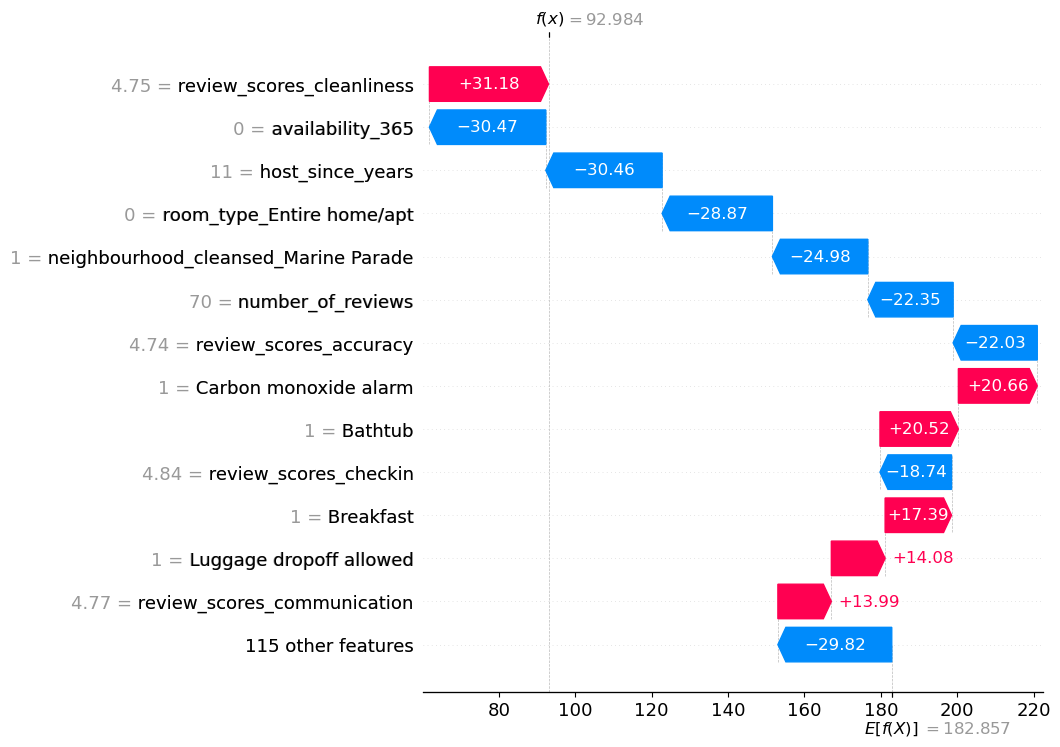

In [10]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[20], max_display=14)

In [11]:
# for i in range(X.shape[1]):
#     print(X.columns[i], "=", model.coef_[i].round(5))

### Model 2: Gradient Boost Regressor

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor

reg = HistGradientBoostingRegressor()

reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

print(f"Train\nScore: {reg.score(X_train, y_train)}")
calculate_score(y_train, y_train_pred)

print(f"Test\nScore: {reg.score(X_test, y_test)}")
calculate_score(y_test, y_pred)

plot(y_test, y_pred)

Train
Score: 0.9473052504241182
R2 Score 0.9473052504241182
RMSE : 30.535310804375417
Test
Score: 0.7640520525218855
R2 Score 0.7640520525218855
RMSE : 62.941342768477845


### Model 3: XGBoost Regression

We can use gradient boosting - a type of ensemble machine learning algorithms. Ensemble is a collection of decision trees. Every iteration, a decision tree is added to model to minimise the error. Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm, and the goal is to minimise loss gradient. We will use XGBoost API to do the model fitting.

Train
Score:1.0
R2 Score 0.9907481501980658
RMSE : 12.794784018083211
Test
Score:0.7729414478612586
R2 Score 0.7729414478612586
RMSE : 61.74429468712888


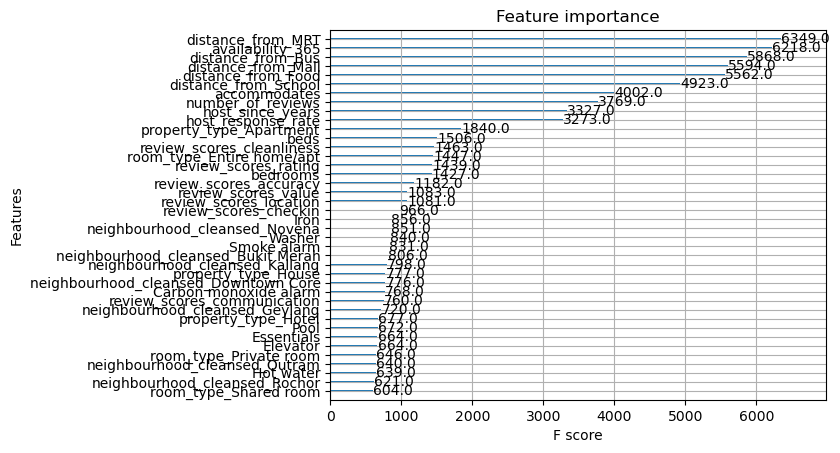

In [13]:
import xgboost as xgb

model = xgb.sklearn.XGBRegressor(tree_method='hist', objective='reg:squarederror', n_estimators = 2500,
                         learning_rate=0.01)

model.fit(X_train.astype('float64'), y_train) # Cast bool -> float64 (0, 1)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print(f"Train\nScore:{model.score(X_train, y_train_pred)}")
calculate_score(y_train, y_train_pred)

print(f"Test\nScore:{model.score(X_test, y_test)}")
calculate_score(y_test, y_pred)

xgb.plot_importance(model.get_booster(), max_num_features=40)

plot(y_test, y_pred)

### Model 4: Neural Networks

In [14]:
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, Y, test_size=0.33, random_state=101)

s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float64))
X_val_and_test = s_scaler.transform(X_val_and_test.astype(np.float64))

X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

In [15]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(256, activation='linear', input_shape=(len(X_val.columns), )))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='linear'))
model.add(Dense(16, activation='linear'))
model.add(Dense(8, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

Input (n layers) -> Hidden Layer(s) (256, 128, ..., 8) -> Output (1 layer): Price

In [16]:
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=600)
model.summary()

Epoch 1/600


2023-04-14 14:10:52.566905: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 0s 6ms/step - loss: 47316.6836 - val_loss: 39468.9023
Epoch 2/600
15/15 [==============================] - 0s 2ms/step - loss: 39636.9883 - val_loss: 34728.8945
Epoch 3/600
15/15 [==============================] - 0s 2ms/step - loss: 34253.2734 - val_loss: 28985.7363
Epoch 4/600
15/15 [==============================] - 0s 2ms/step - loss: 25775.6270 - val_loss: 18148.8574
Epoch 5/600
15/15 [==============================] - 0s 2ms/step - loss: 12067.0928 - val_loss: 7879.9346
Epoch 6/600
15/15 [==============================] - 0s 2ms/step - loss: 9180.5596 - val_loss: 7195.9941
Epoch 7/600
15/15 [==============================] - 0s 2ms/step - loss: 8842.1943 - val_loss: 6438.1069
Epoch 8/600
15/15 [==============================] - 0s 2ms/step - loss: 8056.8379 - val_loss: 6994.3623
Epoch 9/600
15/15 [==============================] - 0s 2ms/step - loss: 7721.3799 - val_loss: 6835.1538
Epoch 10/600
15/15 [==============================] - 0s 2

<Axes: >

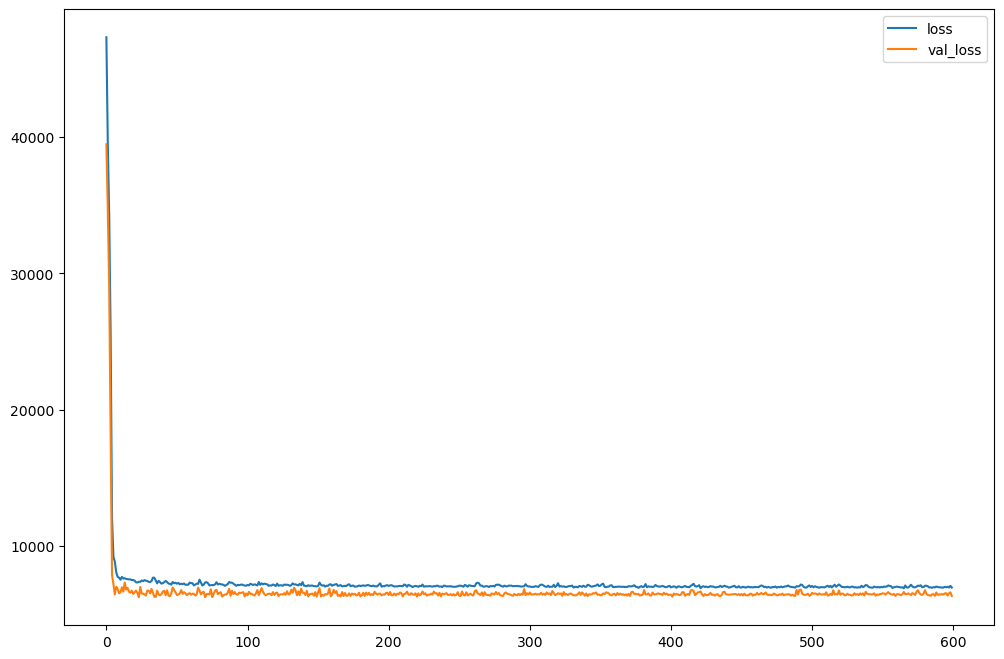

In [17]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))


In [18]:
y_pred = model.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2 Score:',explained_variance_score(y_test,y_pred))
# Visualizing Our predictions

y_pred = np.array(y_pred).flatten()
y_test = np.array(y_test)

plot(y_test, y_pred)


15/15 [==============================] - 0s 559us/step
RMSE: 79.51651552196114
R^2 Score: 0.6304835545554245


We can conclude that HistGradientBoostingRegressor achieve the best results, with the lowest RMSE (~60) and the higher R^2 score (~0.75). All other models achieve decent results, with RMSE around half of standard deviation, and R^2 > 0.5.